## Step-by-step example with CLAGL 

### Setup

In [1]:
import os
import pyBigWig
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, spatial

The following dictionary will help iterate through the peaks and explain scores.

In [2]:
paths = {} 
paths["suffixes"] = ["clagl", "d1msn", "d2msn", "itl6gl", "ptgl", "pvga", "sstga", "vipga"]
paths["chroms"] = "/home/groups/akundaje/jelenter/SVM_pipelines/make_inputs/mm10.chrom.sizes"
paths["explain_scores"] = {}
paths["peaks"] = {}
for suffix in paths["suffixes"]:
    paths["explain_scores"][suffix] = "/oak/stanford/groups/akundaje/projects/aav/explain_scores/"+suffix.upper() \
                                                +"/fold0/"+"split_scores/"+suffix.upper()+".fold0.explain-all.bw"
    paths["peaks"][suffix] = "/home/groups/akundaje/jelenter/ranked_peaks_thousand/"+suffix+".ranked_peaks.tsv" 

### Utils

In [3]:
def bw_to_np(peak_df, explain_scores_bw):
    """
    Convert bigwig explain scores listed in the peak file into list of numpy arrays.
    Input:
        peak_df: pandas dataframe
            Peak list 
        explain_scores_bw: bigwig file
            Explain scores in bigwig format
    Output:
        explain_scores: list of numpy arrays
            explain_scores[i] has the explain scores corresponding to peak i in a numpy array.
    """
    explain_scores = []
    for peak in range(peak_df.shape[0]):
        chrom, start, end = peak_df.iloc[peak, [0,1,2]]
        start = int(start)
        end = int(end)
        explain_scores.append(np.array(explain_scores_bw.values(chrom, start, end)))
    return explain_scores

def max_sliding_window_diff(x, y, window_size=14):
    """
    Computes max sliding window distance between vectors x and y.
    Window size should be big enough (in base pairs) to hold a hypothetical motif.
    """
    max_diff = 0
    for i in range(0, len(x)-window_size):
        diff = np.sum((x[i: i+window_size]-y[i: i+window_size])**2)
        if diff > max_diff:
            max_diff = diff
    return max_diff
    
    
def create_similarity_matrix(exp_scores_dict, similarity, specific_celltype):
    '''
    Create similarity matrix where entry [i,j] holds the similarity between explain scores of the specific cell type and cell type i.
    Similarity is a user-defined function.
    Input:
        exp_scores_dict:
            Dictionary where key "celltype" holds explain scores for that cell type.
        similarity: func
            Similarity function
        specific_celltype: string
            One of ['clagl', 'd1msn', 'd2msn', 'itl6gl', 'ptgl', 'pvga', 'sstga', 'vipga']
    Output: 
        Similarity Matrix: numpy array
    '''
    celltypes = list(exp_scores_dict.keys())
    celltypes.remove(specific_celltype)
    num_peaks = len(exp_scores_dict[celltypes[0]])
    similarity_matrix = np.empty((len(celltypes), num_peaks))
    for i, celltype in enumerate(celltypes):
        for peak_idx in range(num_peaks):
            similarity_matrix[i, peak_idx] = similarity(exp_scores_dict[specific_celltype][peak_idx], exp_scores_dict[celltype][peak_idx])
    return similarity_matrix

def plot_similarity_matrix(similarity_matrix, celltype = "CLAGL"):
    x = np.sum(similarity_matrix, axis = 0)
    y = np.quantile(x, q=0.98) 
    plt.figure(figsize=(8,5))
    plt.plot(x)
    plt.hlines(y, xmin=0, xmax=len(x), colors = 'r', label = "2% threshold")
    plt.xlabel("Peak number")
    plt.ylabel("Average MSW Distance")
    plt.legend()
    plt.title("Average distance between the explain scores of the " + celltype +" model and the other cell types.")

-------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------

### CLAGL specific peaks analysis

-------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------

We'll start by loading the explain scores on the ITL6GL specific peaks of all the models.

In [5]:
explain_scores = {}
clagl_peaks = pd.read_csv(paths["peaks"]["clagl"], sep='\t')
print("Cell Type:")
for celltype in paths["suffixes"]:
    print(celltype)
    # Load all explain scores as lists of numpy arrays for the assumed CLAGL specific peaks
    explain_scores[celltype] = bw_to_np(clagl_peaks, pyBigWig.open(paths["explain_scores"][celltype]))

Cell Type:
clagl
d1msn
d2msn
itl6gl
ptgl
pvga
sstga
vipga


We now compute the similarity (distance) between the explain scores of the model trained on ITL6GL data and the rest of the models at each peak.

We are using the *max sliding window difference* distance function. This distance measure is defined in the following way:

$$
d(\mathbf{x},\mathbf{y}) = max_{i = 1,...,N-w \\  w \in \mathbf{N}} { ||\mathbf{x}[i:i+w] - \mathbf{y}[i:i+w]||^2 \; }
$$


In [13]:
clagl_sim_matrix = create_similarity_matrix(explain_scores, max_sliding_window_diff, "clagl")

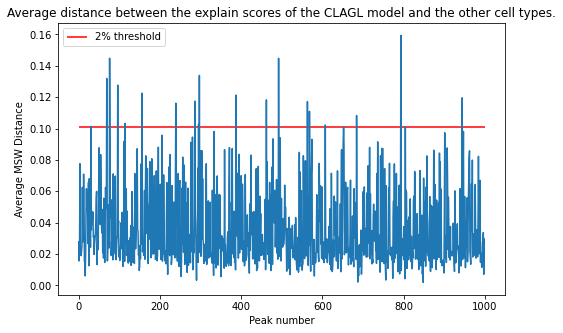

In [24]:
plot_similarity_matrix(clagl_sim_matrix, "CLAGL")

**Selection**: the candidate peaks are those in which the average distance between the explain scores of the ITL6GL model and the explain scores of the rest of the models is in the top 2% (above red line). 

In [25]:
num_peaks = int(0.98*len(clagl_sim_matrix[0]))
candidate_peaks = np.argpartition(np.sum(clagl_sim_matrix, axis = 0), num_peaks)[num_peaks:]

In [26]:
print(candidate_peaks)

[804  30 944 462  69  76 568  96 492 387 684 114 607 156 297 295 286 239
 793 563]


### Our candidates for CLAGL specificity

In [27]:
clagl_peaks.iloc[candidate_peaks]

,chr,start,end,peak,label,phastcons_mean,phastcons_max,phylop_mean,phylop_max,clagl_jsd,clagl_jaccard
804,chr12,39916240,39916792,cCREs99200,chr12:39916240-39916792_cCREs99200,0.81694,1.000,1.05826,2.756,0.604706,0.250000
30,chr16,83039626,83040160,cCREs197982,chr16:83039626-83040160_cCREs197982,0.96258,0.999,1.01340,2.238,0.487730,0.000000
944,chr1,63692795,63693333,cCREs11769,chr1:63692795-63693333_cCREs11769,0.31466,0.429,0.16810,0.278,0.612342,0.000000
462,chr13,34845840,34846341,cCREs121171,chr13:34845840-34846341_cCREs121171,0.90740,0.923,0.22858,0.278,0.581661,0.666667
69,chr11,28850367,28850870,cCREs71270,chr11:28850367-28850870_cCREs71270,0.16626,0.887,0.27862,0.934,0.516523,0.333333
76,chr15,44564134,44564666,cCREs169425,chr15:44564134-44564666_cCREs169425,0.97432,1.000,1.85856,3.185,0.521930,0.000000
568,chr13,111999080,111999637,cCREs137086,chr13:111999080-111999637_cCREs137086,0.75560,0.893,0.35058,1.233,0.589981,0.000000
96,chr14,11175629,11176162,cCREs139530,chr14:11175629-11176162_cCREs139530,0.27296,0.948,0.50396,1.966,0.528160,0.333333
492,chr4,55155301,55155830,cCREs326398,chr4:55155301-55155830_cCREs326398,0.34670,0.485,0.38882,1.322,0.584149,0.000000
387,chr4,107392457,107392969,cCREs336478,chr4:107392457-107392969_cCREs336478,0.32482,0.758,0.42084,2.003,0.574996,0.000000


### Taking a look into some of the selected peaks

#### Candidate 1 (chr16:83039626-83040160) 

Candidate 1 actually has 2 examples of motifs that pop up only in CLAGL.

<img src="../images/candidate1.png" alt="drawing" style="width:600px;"/>
<img src="../images/candidate1bis.png" alt="drawing" style="width:600px;"/>

Looking up the second candidate motif (TGACATTT) in TOM TOM yields the following match in mouse DNA:

<img src="../images/candidate1tomtom.png" alt="drawing" style="width:600px;"/>

#### Candidate 3 (chr5:9943620-9944154)

<img src="../images/candidate3.png" alt="drawing" style="width:600px;"/>

Candidate 16 (chr16:51277483-51277990) yields the same motif as candidate 3 and the second motif of candidate 1.

#### Candidate 9 (chr4:55155301-55155830)

<img src="../images/candidate492.png" alt="drawing" style="width:600px;"/>
<img src="../images/candidate492tomtom.png" alt="drawing" style="width:600px;"/>

Notice that this is the same motif as in candidate 1.


